# Lets goo Facial Expression Recognition

# install

In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

challenges-in-representation-learning-facial-expression-recognition-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
replace example_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: example_submission.csv  
replace fer2013.tar.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: fer2013.tar.gz          
replace icml_face_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: icml_face_data.csv      y
y
y

replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: train.csv               y



In [7]:
!pip install wandb onnx -Uq

# Wandb and conf staff

In [8]:
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# remove slow mirror from list of MNIST mirrors
torchvision.datasets.MNIST.mirrors = [mirror for mirror in torchvision.datasets.MNIST.mirrors
                                      if not mirror.startswith("http://yann.lecun.com")]

In [9]:
import wandb

In [10]:
wandb.login()

wandb: Currently logged in as: konstantine25b (konstantine25b-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [11]:
run = wandb.init(
    entity="konstantine25b-free-university-of-tbilisi-",
    project="Facial_Expression_Recognition_1",
    config={
        "learning_rate": 0.02,
        "architecture": "Simple Neural Network (2 hidden layers, 64 neurons each, ReLU activation)",
        "dataset": "Facial Expression Recognition Challenge",
        "epochs": 10,
        "batch_size": 64,
        "optimizer": "Adam",
        "loss_function": "Cross-Entropy Loss"
    },
)

In [12]:
import wandb
import os
import pandas as pd # Assuming you might need pandas for data loading

# Assuming the data is in a directory named 'train' and 'test' after unzipping
# You might need to adjust the paths based on how the data is structured

# Example: Load data using pandas if you have a CSV file with labels/metadata
# data_dir = "path/to/your/unzipped/data" # Replace with the actual path
# train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
# test_df = pd.read_csv(os.path.join(data_dir, "test.csv"))

# Create a wandb artifact
# Reference [1] explains how to create an artifact with a type and project
raw_data_artifact = wandb.Artifact(
    name="facial-expression-dataset",
    type="dataset",
    description="Facial Expression Recognition Challenge Dataset"
)

# Add data to the artifact
# You would typically add the directory containing your images and any metadata files
# raw_data_artifact.add_dir(data_dir) # Add the entire data directory

# If you have individual files, you can add them like this:
# raw_data_artifact.add_file(os.path.join(data_dir, "train.csv"))
# raw_data_artifact.add_file(os.path.join(data_dir, "test.csv"))
# You will need to adapt this part based on the actual file structure of the downloaded data

# Log the artifact to the current run
wandb.log_artifact(raw_data_artifact)

print("Data loaded and logged as a wandb artifact.")

Data loaded and logged as a wandb artifact.


In [13]:
import matplotlib.pyplot as plt
from PIL import Image

artifact = run.use_artifact('facial-expression-dataset:latest')

# Download the data from the artifact
# You might need to specify a directory to download to
data_dir = artifact.download()


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm

In [15]:
# Load the original training data
original_train_df = pd.read_csv('train.csv')

# First split: Create a test set (10% of original data)
train_val_df, test_df = train_test_split(original_train_df, test_size=0.1,
                                         random_state=42, stratify=original_train_df['emotion'])

# Second split: Split remaining data into training (80%) and validation (20%)
train_df, val_df = train_test_split(train_val_df, test_size=0.2,
                                    random_state=42, stratify=train_val_df['emotion'])

# Define emotion labels
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
                  4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [16]:
print(f"Original data size: {len(original_train_df)}")
print(f"Training set size: {len(train_df)} ({len(train_df)/len(original_train_df)*100:.1f}%)")
print(f"Validation set size: {len(val_df)} ({len(val_df)/len(original_train_df)*100:.1f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(original_train_df)*100:.1f}%)")

# Print class distribution in each set
print("\nEmotion distribution:")
for i, emotion in emotion_labels.items():
    train_count = sum(train_df['emotion'] == i)
    val_count = sum(val_df['emotion'] == i)
    test_count = sum(test_df['emotion'] == i)
    print(f"  {emotion}: Train={train_count}, Val={val_count}, Test={test_count}")

Original data size: 28709
Training set size: 20670 (72.0%)
Validation set size: 5168 (18.0%)
Test set size: 2871 (10.0%)

Emotion distribution:
  Angry: Train=2877, Val=719, Test=399
  Disgust: Train=314, Val=78, Test=44
  Fear: Train=2950, Val=737, Test=410
  Happy: Train=5194, Val=1299, Test=722
  Sad: Train=3477, Val=870, Test=483
  Surprise: Train=2283, Val=571, Test=317
  Neutral: Train=3575, Val=894, Test=496


In [ ]:
def pixels_to_image(pixels_str):
    pixels = [int(pixel) for pixel in pixels_str.split()]
    image = np.array(pixels).reshape(48, 48)
    return image

# Create a figure with sample images from each class
plt.figure(figsize=(14, 3))
for i, emotion in emotion_labels.items():
    sample = train_df[train_df['emotion'] == i].iloc[0]
    img = pixels_to_image(sample['pixels'])

    plt.subplot(1, 7, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

plt.tight_layout()
plt.savefig('emotion_samples.png')
plt.show()

# Log the examples to wandb
wandb.log({"emotion_samples": wandb.Image('emotion_samples.png')})

: 

In [18]:
class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        pixels = [int(pixel) for pixel in row['pixels'].split()]
        image = np.array(pixels, dtype=np.uint8).reshape(48, 48)

        # Convert to PIL Image for transforms
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = row['emotion']
        return image, label

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets
train_dataset = FER2013Dataset(train_df, transform=transform)
val_dataset = FER2013Dataset(val_df, transform=transform)
test_dataset = FER2013Dataset(test_df, transform=transform)


In [20]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [21]:
class TinyNN(nn.Module):
    def __init__(self):
        super(TinyNN, self).__init__()
        # Input layer: flatten the 48x48 image to a vector of size 2304
        self.flatten = nn.Flatten()

        # First hidden layer: 2304 -> 64 neurons
        self.fc1 = nn.Linear(48 * 48, 64)
        self.relu1 = nn.ReLU()

        # Output layer: 64 -> 7 emotions
        self.fc2 = nn.Linear(64, 7)

    def forward(self, x):
        # Flatten the input image
        x = self.flatten(x)

        # First layer
        x = self.fc1(x)
        x = self.relu1(x)

        # Output layer
        x = self.fc2(x)
        return x

In [22]:
model = TinyNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

# Log model architecture to wandb
wandb.watch(model, log="all")

In [23]:
num_epochs = 10

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Use tqdm for progress bar
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:  # Using validation set
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc
    })

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


: 

In [25]:
torch.save(model.state_dict(), 'fer2013_tinyNN_model.pth')
wandb.save('fer2013_tinyNN_model.pth')

['/content/wandb/run-20250525_093734-b9u0qn1x/files/fer2013_tinyNN_model.pth']

In [26]:

# Final evaluation on test set
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader)
test_acc = 100 * test_correct / test_total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})


Test Loss: 1.9696, Test Accuracy: 30.76%


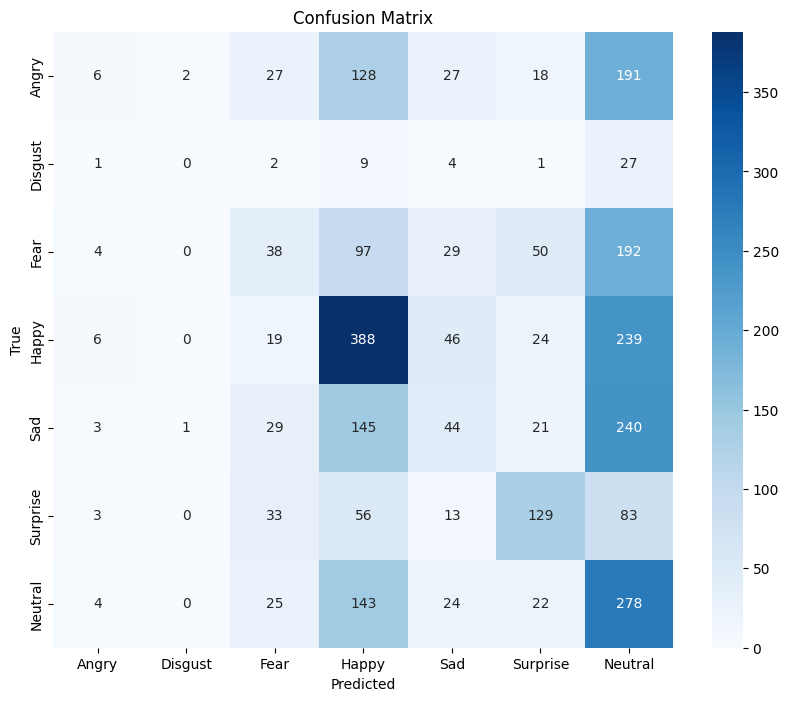

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(emotion_labels.values()),
            yticklabels=list(emotion_labels.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Log confusion matrix to wandb
wandb.log({"confusion_matrix": wandb.Image('confusion_matrix.png')})

In [28]:
report = classification_report(all_labels, all_preds,
                               target_names=list(emotion_labels.values()))
print(report)

              precision    recall  f1-score   support

       Angry       0.22      0.02      0.03       399
     Disgust       0.00      0.00      0.00        44
        Fear       0.22      0.09      0.13       410
       Happy       0.40      0.54      0.46       722
         Sad       0.24      0.09      0.13       483
    Surprise       0.49      0.41      0.44       317
     Neutral       0.22      0.56      0.32       496

    accuracy                           0.31      2871
   macro avg       0.26      0.24      0.22      2871
weighted avg       0.30      0.31      0.26      2871



In [ ]:
plt.figure(figsize=(15, 10))
test_samples = 5
for i in range(test_samples):
    # Get random test image
    idx = np.random.randint(0, len(test_dataset))
    img, label = test_dataset[idx]

    # Make prediction
    img_tensor = img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)

    # Display image with true and predicted labels
    plt.subplot(1, test_samples, i+1)
    plt.imshow(img.squeeze().cpu().numpy(), cmap='gray')
    plt.title(f"True: {emotion_labels[label]}\nPred: {emotion_labels[predicted.item()]}")
    plt.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png')
plt.show()

wandb.log({"sample_predictions": wandb.Image('sample_predictions.png')})

# Finish the wandb run
wandb.finish()

: 